# Сетевой супермаркет «Хлеб-Соль»   
**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:   
1. Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
2. Контролировать добросовестность кассиров при продаже алкоголя.
   
Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.
Инструкция по выполнению проекта
Проведите исследовательский анализ набора фотографий.
Подготовьте данные к обучению.
Обучите нейронную сеть и рассчитайте её качество.

# Исследовательский анализ данных

In [36]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os.path
import seaborn as sns
import numpy as np
import scipy.stats as st

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 29)

prjct_name = '14 Компьютерное зрение'

label_name = 'labels.csv'
data_fldr= '/datasets/faces/final_files/'
path_to_prjct = ['MyDrive', 'Data Science', 'Проекты', prjct_name]

local_path = os.path.join('G:' + os.sep, *map(''.join, path_to_prjct), data_fldr, label_name)
web_path = os.path.join(os.sep, 'datasets', 'faces', label_name)

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [37]:
try:
    labels = pd.read_csv(web_path)
except FileNotFoundError:
    labels = pd.read_csv(local_path)
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=data_fldr,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [38]:
labels.info

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

Видим размер выборки - 7591 строк.

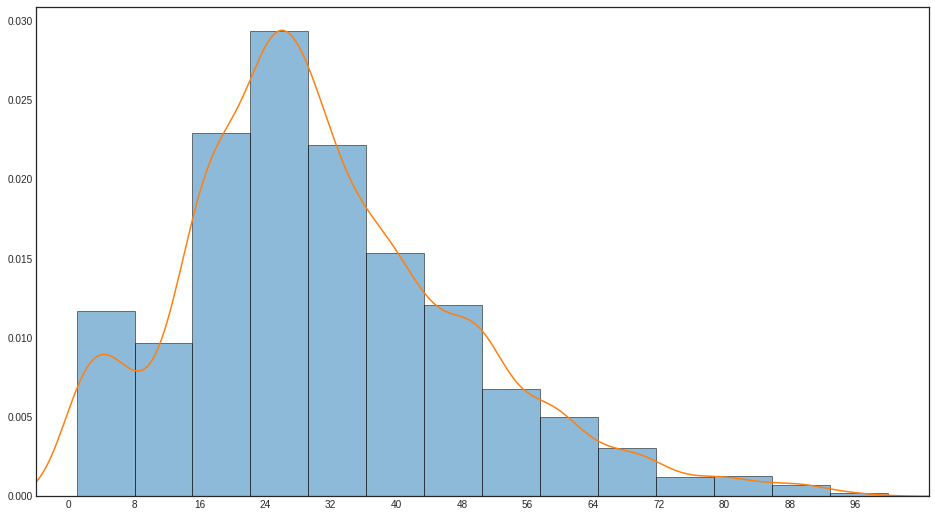

In [39]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.figure(figsize=(16,9))
plt.hist(labels['real_age'], 
         bins='sturges', 
         edgecolor = 'black', 
         alpha=0.5, 
         label=['Распределение возраста в выборке'],
         density=True)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(labels['real_age'])
plt.plot(kde_xs, kde.pdf(kde_xs))
plt.xticks(range(0, max(labels['real_age']), 8))
plt.show();


По гистограмме видим Гауссовское распределение смещённое влево. Выборка, очевидно, корреспондирует потоку покупателей магазина в возрастном выражении, где большинство посетителей приходится на возраст от прибл. 22 до прибл. 29. Также видим нормальное начало гистограмы на значениях возраста от прибл. 1 лет и окончания на возрате до прибл. 100 лет.

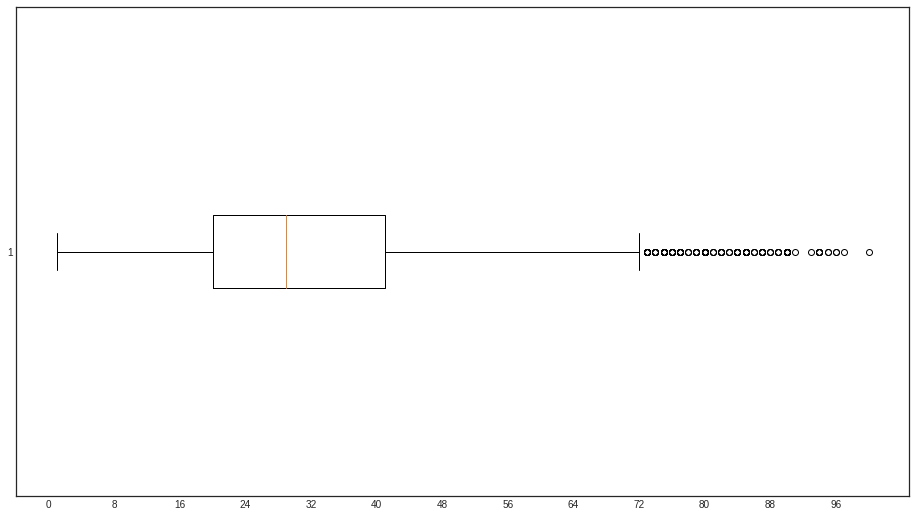

In [40]:
plt.figure(figsize=(16,9))
plt.boxplot(labels['real_age'], vert=False)
plt.xticks(range(0, max(labels['real_age']), 8));

По "ящику с усами" видим также соответствие выборки реальному потоку клиентов, что может свидетельствовать о получении набора данных путём непосредственного анкетирования посетителей при совершении покупок. Исходя из такого распределения вероятность ошибок на группах вне "ящика значений" будет выше, т.к. модель будет иметь меньшее число образцов для обучения в этих группах. Однако, статистически сервис будет давать положительную удовлетворнность потребителей по причине той же самой доминации и активности группы большинства по возрасту. В этой связи магазину нужно будет дорабатывать решение по обеспечению достижения удовлетворённости сервисом старшей группой покупателей.

In [42]:
feature, target = next(train_gen_flow)

9


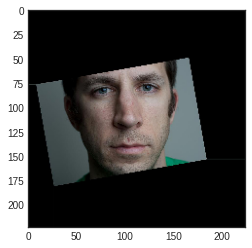

13


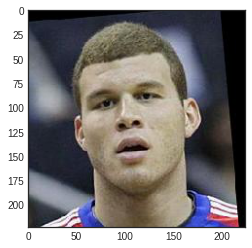

4


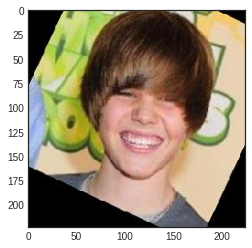

13


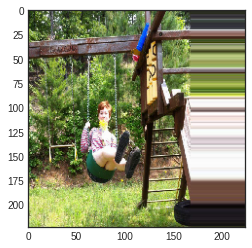

6


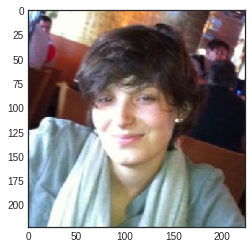

8


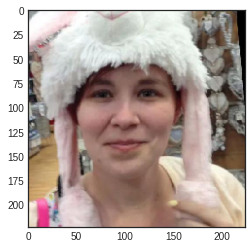

8


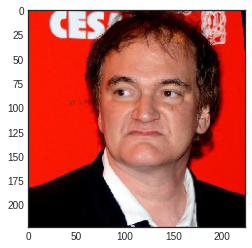

0


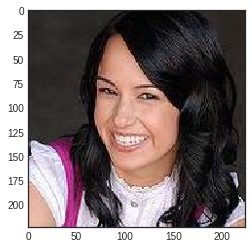

9


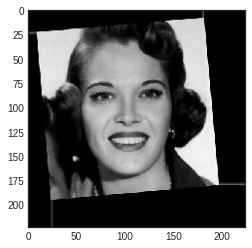

3


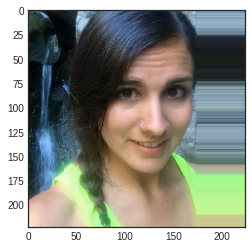

11


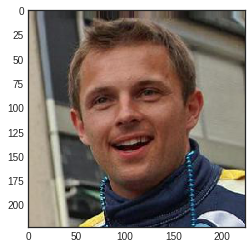

9


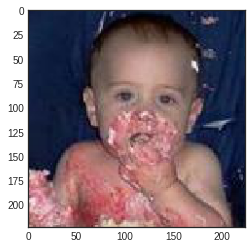

4


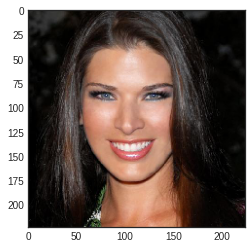

9


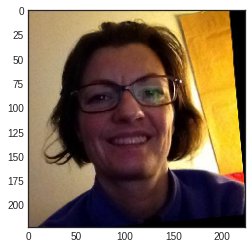

6


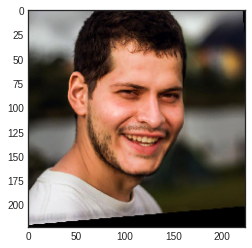

In [43]:
from scipy.stats import randint as sp_randint
g = sp_randint(0, 14)
for i in g.rvs(15):
    print(i)
    plt.imshow(feature[i])
    plt.show();
    feature, target = next(train_gen_flow)

Осмотрев изображения, замечаем, что к ним применены методы аугментации (поворота, частичной деформации, грэйскалинга и т.д.)

# Обучение модели

In [104]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50 


def load_train(path):
    labels = pd.read_csv(web_path)
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = data_fldr,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(web_path)
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = data_fldr,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow
    

def create_model(input_shape):
    optimizer = Adam(lr=0.0005)
    model = Sequential()
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, input_shape=input_shape, activation='softmax'))
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=32, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-09-15 00:09:14.655465: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-09-15 00:09:18.649041: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 64s - loss: 249.4191 - mae: 11.2087 - val_loss: 1018.2241 - val_mae: 27.1074
Epoch 2/10
178/178 - 37s - loss: 65.3591 - mae: 6.0659 - val_loss: 787.2102 - val_mae: 22.6966
Epoch 3/10
178/178 - 37s - loss: 32.1945 - mae: 4.3438 - val_loss: 702.8432 - val_mae: 21.0348
Epoch 4/10
178/178 - 37s - loss: 20.0422 - mae: 3.4598 - val_loss: 188.8940 - val_mae: 9.9404
Epoch 5/10
178/178 - 37s - loss: 16.0978 - mae: 3.1051 - val_loss: 87.6125 - val_mae: 7.1859
Epoch 6/10
178/178 - 37s - loss: 12.9025 - mae: 2.7411 - val_loss: 81.0768 - val_mae: 6.9375
Epoch 7/10
178/178 - 37s - loss: 10.0846 - mae: 2.4103 - val_loss: 75.2479 - val_mae: 6.4427
Epoch 8/10
178/178 - 37s - loss: 8.4207 - mae: 2.2144 - val_loss: 70.9927 - val_mae: 6.4403
Epoch 9/10
178/178 - 37s - loss: 7.4802 - mae: 2.0804 - val_loss: 70.7572 - val_mae: 6.2892
Epoch 10/10
178/178 - 37s - loss: 6.6819 - mae: 1.9794 - val_loss: 66.3571 - val_mae: 6.1203
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 66.3571 - mae: 6.1203
Test MAE: 6.1203

# Анализ обученной модели

В соответствии с заданием нами проведён исследовательский анализ данных педоставленного датасета, содержащего изображения лиц людей размеченных при признаку возрастом изображенного человека. В результате анализа мы установили, что распередление возрастов изображенных людей стремится к нормальному со смещением влево. Исодя из такого распределения можно сделать вывод, что качество распознавания возрастов людей старшего возраста при обучении модели на такой выборке будет ниже качетсва распознавания лиц молодых людей. Рассмотрев набор изображений датасета приходим к выводу, что часть изображений подвергнута аугментации, поэтому данную процедуру в данном проекте не используем, учитывая количественную достаточность выборки для обучения модели.

На следующем этапе нами обучена модель линейной регрессии, с применением предобученной модели ResNet50, которая позволяет преодолеть переобучение модели в нашем проекте. Также нами использована технология пуллинга с усреднением (GlobalAveragePooling2D()). На выходе использована полносвязная сеть с 1 нейроном для предсказания возраста по изображению человека. После тюнинга параметров удалось добиться поставленной задачи по точности предсказаний расчитаной по метрике средней абсолютной ошибки (MAE).


# Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы